# Lorenz (1963)モデル

## 非線型前方モデル

Lorenz方程式は強制熱対流を理想化したモデルである。

$$
\begin{align}
\dot{X} &= -\sigma X + \sigma Y \\
\dot{Y} &= -XZ + rX -Y \\
\dot{Z} &= XY - \beta Z
\end{align}
$$

ここで$\sigma$はPrandtl数，$r$はRayleigh数，$\beta$はアスペクト比を表す。
$X, Y, Z$はそれぞれ無次元化された対流の強さ，最大温度差，対流に伴う成層の変化を表している。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def florenz(w, p, r, b):
    x, y, z = w
    dw = np.zeros_like(w)
    dw[0] =      -p * x + p * y 
    dw[1] = (r - z) * x -     y 
    dw[2] =           x * y     - b * z
    return dw

## 接線型モデル

$$
\begin{align}
\dot{\delta X} &= -\sigma \delta X + \sigma \delta Y \\
\dot{\delta Y} &= -\delta XZ -X\delta Z + r\delta X - \delta Y \\
\dot{\delta Z} &= \delta XY X\delta Y - b\delta Z
\end{align}
$$

In [3]:
def tlorenz(wt, wb, p, r, b):
    dw = np.zeros_like(wt)
    xt, yt, zt = wt
    xb, yb, zb = wb
    dw[0] =       -p * xt +  p * yt 
    dw[1] = (r - zb) * xt -      yt - xb * zt
    dw[2] =       yb * xt + xb * yt -  b * zt
    return dw

## 随伴モデル

$$
\begin{align}
\delta X^{\mathrm{a}} &= \delta X^\mathrm{a} - \sigma\dot{\delta X}^\mathrm{a} + (r-Z)\dot{\delta Y}^\mathrm{a} + Y\dot{\delta Z}^\mathrm{a} \\
\delta Y^{\mathrm{a}} &= \delta Y^{\mathrm{a}} + \sigma\dot{\delta X}^\mathrm{a} - \dot{\delta Y}^\mathrm{a} + X\dot{\delta Z}^\mathrm{a} \\
\delta Z^\mathrm{a} &= \delta Z^\mathrm{a} - X\dot{\delta Y}^\mathrm{a} - b\dot{\delta Z}^\mathrm{a}
\end{align}
$$

In [4]:
def alorenz(wa, dwa, wb, p, r, b):
    xb, yb, zb = wb
    dxa, dya, dza = dwa
    wa[0] = wa[0] - p * dxa + (r - zb) * dya + yb * dza
    wa[1] = wa[1] + p * dxa -            dya + xb * dza
    wa[2] = wa[2]           -       xb * dya -  b * dza
    dwa[:] = 0.0
    return wa, dwa

## 時間積分

計算結果をNumpy形式で保存し，最終結果を返す。接線型モデルと随伴モデルは計算に用いる基本場のファイルを読む。時間積分はオイラー法。

In [5]:
def fom(w, param):
    p, r, b, dt, nstop = param
    fw = np.zeros([nstop+1, w.size])
    fw[0, :] = w
    for ntim in range(1, nstop+1):
        w = w + dt * florenz(w, p, r, b)
        fw[ntim, :] = w
    return fw


def tlm(tl, wb, param):
    p, r, b, dt, nstop = param
    for ntim in range(nstop):
        tl = tl + dt * tlorenz(tl, wb[ntim], p, r, b)
    return tl


def adm(wb, wo, tobs, param, ltest=False):
    p, r, b, dt, nstop = param
    wa = np.zeros(3)
    dwa = np.zeros(3)
    i = tobs.size - 1
    for ntim in range(nstop, 0, -1):
        if ntim == tobs[i]:
            d = wb[ntim, :] - wo[i, :]
            wa = wa + d
            i = i - 1
        dwa = dwa + dt * wa
        wa, dwa = alorenz(wa, dwa, wb[ntim-1], p, r, b)
    return wa

## 観測

予報－観測，コスト函数の計算，観測の生成。

In [6]:
def calc_cost(wb, wo):
    return 0.5 * ((wb - wo)**2).sum()

def gen_obs(e, wt, iobs, seed=514):
    rng = np.random.default_rng(seed)
    wo = wt[iobs::iobs, :].copy()
    tobs = np.array([i for i in range(iobs, wt.shape[0], iobs)])
    for i in range(wo.shape[0]):
        wo[i, :] = wo[i, :] + e[:] * 2.0 * (rng.random(e.size) - 0.5)
    return wo, tobs

### 変分法データ同化

In [7]:
def run_vda(w, wo, tobs, param, alpha=5e-4, istart=1, istop=100, cycles=[]):
    cost = np.zeros([istop-istart+1])
    hist = []
    for ncyc in range(istart, istop+1):
        if ncyc > istart:
            ad = adm(fw, wo, tobs, param)
            w = fw[0, :] - alpha * ad
        fw = fom(w, param)
        if ncyc in cycles:
            hist.append(fw)
        cost[ncyc-istart] = calc_cost(fw[tobs], wo)
#        print(f"{ncyc}: {cost[ncyc-istart]} w={w}")
    return cost, hist

## 実行

パラメタの設定

In [8]:
import sys
import numpy as np

p = 10.0
r = 32.0
b = 8 / 3
nstop = 200
dt = 0.01

### 初期値依存性

In [9]:
nstop = 500
param = p, r, b, dt, nstop
w = np.array([1, 3, 5])
f1 = fom(w, param)
w1 = w * 1.1
f2 = fom(w, param)

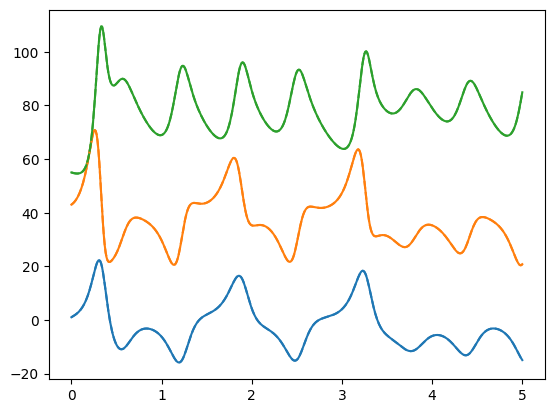

In [10]:
x = np.linspace(0, dt*nstop, nstop+1)
off1, off2 = 40, 50
f1[:, 1] = f1[:, 1] + off1
f1[:, 2] = f1[:, 2] + off2
fig, ax = plt.subplots()
ax.plot(x, f1)
plt.gca().set_prop_cycle(None)
f2[:, 1] = f2[:, 1] + off1
f2[:, 2] = f2[:, 2] + off2
ax.plot(x, f2, linestyle="--")
plt.show()

In [11]:
iobs = 60
nstop = 200
param = p, r, b, dt, nstop
w = np.array([1., 3., 5.])
e = 0.1 * w
wt = fom(w, param)
wo, tobs = gen_obs(e, wt, iobs)

### 変分法データ同化

In [12]:
cycles=[1, 2, 3, 5, 10, 30]
cost, hist = run_vda(w1, wo, tobs, param, cycles=cycles)

In [13]:
%timeit run_vda(w1, wo, tobs, param)

92.4 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


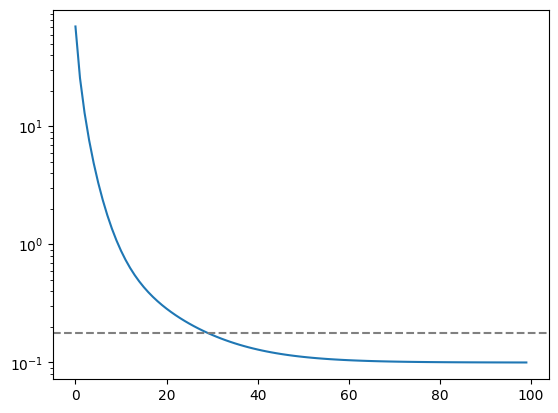

In [14]:
costc = calc_cost(wt[tobs], wo)

fig, ax = plt.subplots()
ax.semilogy(cost)
ax.axhline(costc, c="gray", linestyle="--")
plt.show()

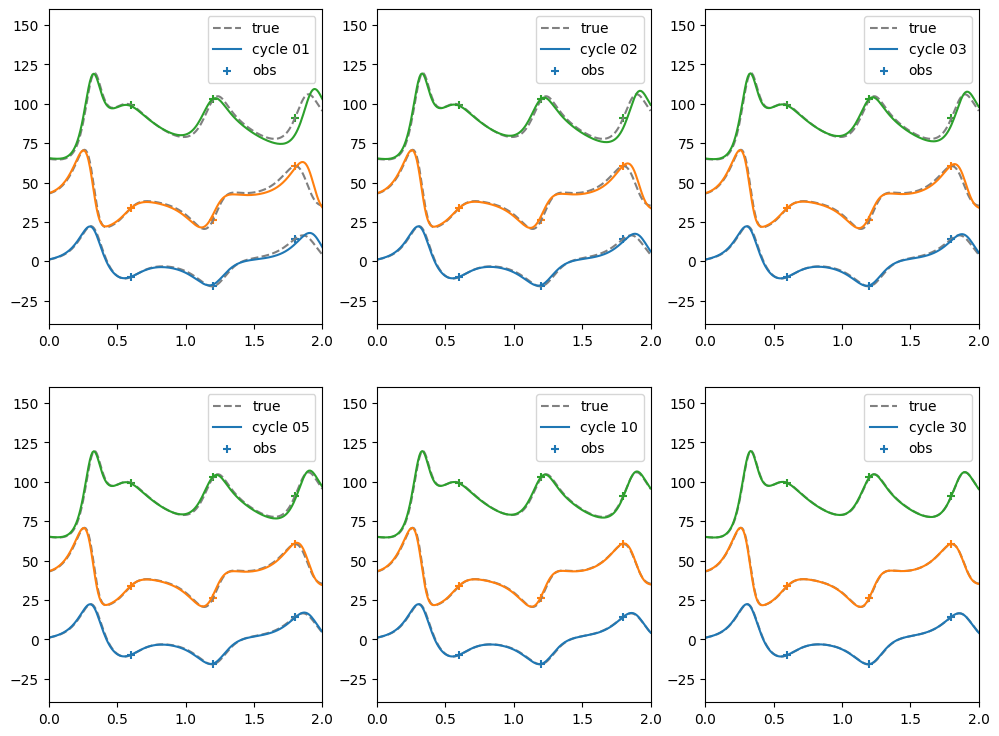

In [15]:
x = np.linspace(0, dt * nstop, nstop+1) 
xt = tobs * dt

nx, ny = 2, 3
off1, off2 = 40, 60
fig, ax = plt.subplots(nx, ny, figsize=[12, 9])
wtrue = wt.copy()
wtrue[:, 1] += off1
wtrue[:, 2] += off2
wobs = wo.copy()
wobs[:, 1] += off1
wobs[:, 2] += off2

k = 0
for n in range(len(cycles)):
    ncyc = cycles[n]
    i, j = k // ny, k % ny
    k += 1
    w = hist[n]
    w[:, 1] += off1
    w[:, 2] += off2
    ax[i, j].plot(x, wtrue, c="gray", linestyle="--", label=["true","",""])
    ax[i, j].plot(x, w, label=[f"cycle {ncyc:02}","",""])
    ax[i, j].set_prop_cycle(None)
    ax[i, j].scatter(xt, wobs[:,0], marker="+", label="obs")
    ax[i, j].scatter(xt, wobs[:,1], marker="+")
    ax[i, j].scatter(xt, wobs[:,2], marker="+")
    ax[i, j].set_xlim([0.0, 2.0])
    ax[i, j].set_ylim([-40, 160])
    ax[i, j].legend(loc="upper right")

# 参考文献
* Lorenz, E. N, 1963: Deterministic nonperiodic flow. _J. Atmos. Sci._, __20__, 130&ndash;141, [doi:10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2).
* Huang, X.-Y. and X. Yang, 1996: Variational data assimilation with the Lorenz model. [Technical Report 26](http://hirlam.org/index.php/publications-54/hirlam-technical-reports-a/doc_view/1317-hirlam-technical-report-no-26), HIRAM, April 1996, 44 pp.